In [607]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

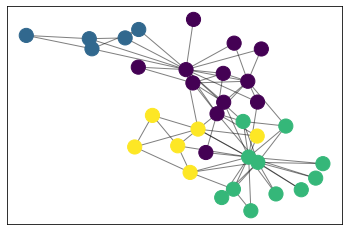

In [608]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [609]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

Gateway graph nodes: [5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]


In [610]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
for i in range(0,500):
    g = G
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g)

for k in range(0,500):
    tot_g[k].add_nodes_from(gateNodesList)
    for i in range(0,len(gateEdges)):
        tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))

In [611]:
#BCS Score
def BCS(gg,nodes):
    BCS_=[0]*(nodes+1)
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        #print(x)
        for j in x:
            BCS_[j]+=(1/10)*x[j]
    #BCS_=[round(i,3) for i in BCS_]
    return BCS_
BCSSS=BCS(tot_g,max([max(a[0],a[1]) for a in gateEdges]))
BCS_value={}
for i in range(1,max([max(a[0],a[1]) for a in gateEdges])+1):
    BCS_value[i]=BCSSS[i]
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 23.295454545454646), (32, 20.265151515151505), (33, 13.115530303030178), (34, 12.452651515151665), (11, 9.777462121212112), (6, 7.386363636363603), (4, 4.924242424242396), (2, 4.7348484848484755), (24, 4.640151515151545), (3, 4.2613636363636), (28, 3.7405303030302792), (26, 1.3257575757575832), (8, 0.9469696969697092), (9, 0.8522727272727291), (5, 0.0), (7, 0.0), (10, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (25, 0.0), (27, 0.0), (29, 0.0), (30, 0.0), (31, 0.0)]


In [612]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 3225.51it/s]


In [613]:
print(time_of_diffusion)

{1: 33, 2: 34, 3: 32, 4: 45, 5: 52, 6: 39, 7: 43, 8: 49, 9: 46, 10: 0, 11: 80, 12: 50, 13: 46, 14: 37, 15: 116, 16: 42, 17: 50, 18: 53, 19: 55, 20: 58, 21: 111, 22: 63, 23: 40, 24: 61, 25: 59, 26: 65, 27: 56, 28: 47, 29: 34, 30: 57, 31: 52, 32: 62, 33: 53, 34: 38}


In [614]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 32, 33]
[5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]
44


In [615]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[29, 20]


In [616]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

  0%|          | 0/200 [00:00<?, ?it/s]

78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78


100%|██████████| 200/200 [00:00<00:00, 4000.31it/s]

78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78


100%|██████████| 200/200 [00:00<00:00, 2409.74it/s]

78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


 90%|█████████ | 180/200 [00:00<00:00, 1782.28it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5264.43it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 4761.84it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5406.04it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 5129.64it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 5261.62it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 5001.20it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 4762.55it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5404.30it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5264.23it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 4082.27it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 4762.57it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5002.36it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


100%|██████████| 200/200 [00:00<00:00, 3226.05it/s]


78
78
78


100%|██████████| 200/200 [00:00<00:00, 4082.21it/s]

78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 4878.46it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 5128.58it/s]


78
78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


100%|██████████| 200/200 [00:00<00:00, 5000.54it/s]

78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5406.32it/s]

78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78


100%|██████████| 200/200 [00:00<00:00, 5000.81it/s]

78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5000.12it/s]

78
78
78



100%|██████████| 200/200 [00:00<00:00, 5714.39it/s]

78
78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5879.98it/s]

78
78
78
78
78



  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5556.22it/s]


78
78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78
78


  0%|          | 0/200 [00:00<?, ?it/s]

78
78
78
78
78


100%|██████████| 200/200 [00:00<00:00, 5880.88it/s]

78
78
78
78



100%|██████████| 200/200 [00:00<00:00, 6056.67it/s]

78
78


In [617]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

44


100%|██████████| 200/200 [00:00<00:00, 4545.91it/s]


100%|██████████| 200/200 [00:00<00:00, 5558.17it/s]


100%|██████████| 200/200 [00:00<00:00, 5128.33it/s]


[[7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 6.200838896271716e-10, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 1.8071357326824382e-08, 1.4302201963254243e-175, 1.4302201963254243e-175, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 4.4046270399503046e-08, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134], [7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 1.8479903332880594e-175, 7.740005987670077e-134, 9.241056108922433e-175, 7.740005987670077e-134, 4.77190349362946e-08, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 7.740005987670077e-134, 4.665733707924567e-08, 1.6197576827058084e-175, 7.740005987670077e-134, 7.740005987670077e-134], [2.886424152483645e-175, 7.74000598

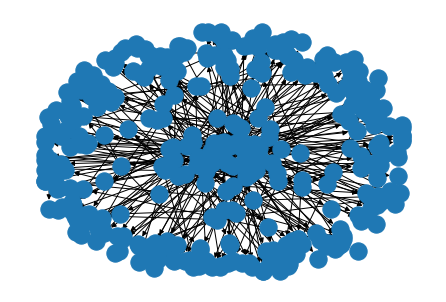

In [618]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [619]:
print(allDiffusionTime)

[{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 28: 0, 6: -1, 7: -1, 9: -1, 11: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1, 10: -1, 14: -1, 20: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: 0, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: 0, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 31: 0, 28: -1, 29: -1, 30: -1, 24: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 32: 0, 29: 55, 28: -1, 30: -1, 24: -1, 31: -1,

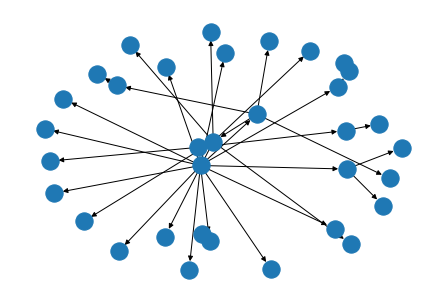

In [620]:
nx.draw(nx.bfs_tree(g, source = 5))

In [621]:
print(len(toTakeArgmax[0]),len(toTakeArgmax))

20 19


In [622]:
finArg = np.argmax(toTakeArgmax,axis=1)

In [623]:
id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

In [624]:
print(clusterNode)

20


In [625]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

0


In [641]:
print(partition[10])

0


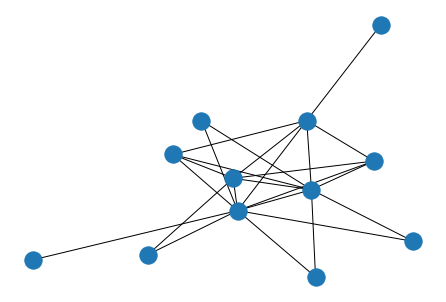

In [627]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [628]:
myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print(myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


{1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22}
list [1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22]


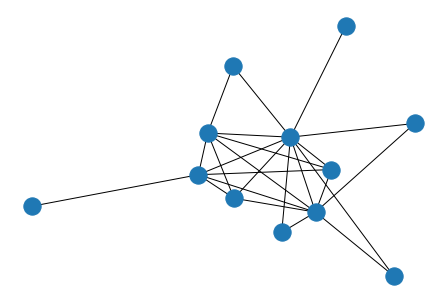

In [629]:
cG = G.subgraph(my)
nx.draw(cG)

500


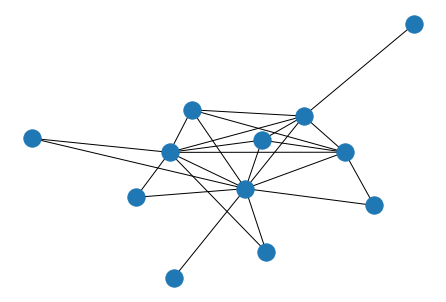

In [630]:
tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_g[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_g[7].subgraph(my))

In [631]:
print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
BCSSS_cg=BCS(tot_cg,len(tot_cg)+2)
print(BCSSS_cg)
BCS_value_cg={}
for i in range(1,max([max(a[0],a[1]) for a in cG.edges()])+1):
    BCS_value_cg[i]=BCSSS_cg[i]
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))
print(BCS_value_cg)

24
nodes_in_cg [1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22]
[0, 22.727272727272865, 19.090909090909307, 9.090909090909115, 15.454545454545563, 0, 0, 0, 3.6363636363636562, 0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [632]:
# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2438.98it/s]


In [633]:
print(time_of_diffusion_cg)

{1: 1, 2: 20, 3: 0, 4: 26, 5: -1, 6: -1, 7: -1, 8: 19, 9: -1, 10: 15, 11: -1, 12: 57, 13: 36, 14: 35, 15: -1, 16: -1, 17: -1, 18: 15, 19: -1, 20: 29, 22: 13}


In [634]:
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print(sensor_nodes_cg)

[1, 2, 4]


In [635]:
delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)

[19, 25]


100%|██████████| 200/200 [00:00<00:00, 7147.21it/s]


100%|██████████| 200/200 [00:00<00:00, 7407.75it/s]


[[8.966550752510679e-07, 1.0999410818962503e-75, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 6.213058822892006e-10], [2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 1.1983404166170686e-79, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102, 1.0999410818962503e-75, 2.371871925555801e-102], [2.371871925555801e-102, 2.3718719255

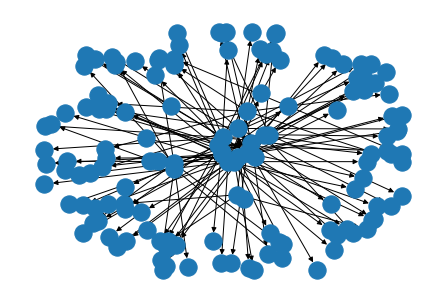

In [636]:
g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=[]
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t_cg,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg.append(fun_cg)
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print(toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [637]:
print(len(toTakeArgmax_cg[0]),len(toTakeArgmax_cg))

20 12


In [638]:
finArg_cg = np.argmax(toTakeArgmax_cg,axis=1)

In [639]:
id_cg=-1
mx_cg=-1
for i in range(0,len(finArg_cg)):
    if(toTakeArgmax_cg[i][finArg_cg[i]]>mx):
        mx_cg=toTakeArgmax_cg[i][finArg_cg[i]]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print(source_node)

14


In [642]:
print(partition[source_node])
print(partition[10])

0
0
